In [20]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix

import catboost

In [21]:
df = pd.read_csv('./data/AirPass.csv', index_col=0)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [22]:
# Задание 6.1
# Для начала сделаем небольшую предобработку данных. Сколько всего в данных пропущенных значений?
df.isna().sum().sum()


310

In [23]:
# Задание 6.2
# Теперь давайте избавимся от найденных пропусков. Заполните их все медианными значениями. После этого вычислите среднее
# арифметическое для признака, отражающего задержку при прибытии в минутах. Ответ округлите до двух знаков после точки-разделителя.

df = df.fillna(df.median())
round(df['Arrival Delay in Minutes'].mean(), 2)


15.13

satisfaction             Gender
neutral or dissatisfied  Female    30193
                         Male      28686
satisfied                Female    22534
                         Male      22491
Name: Gender, dtype: int64

Text(0.5, 1.0, 'Не удволетворенность полетом')

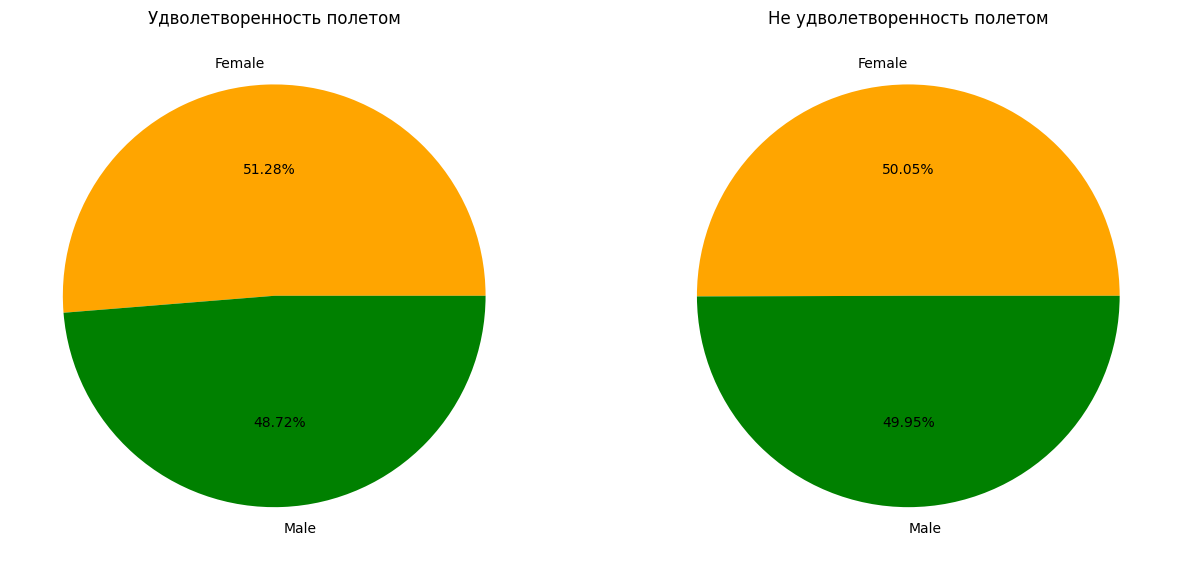

In [24]:
# Задание 6.3
# Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом
# клиенты.
# 1. Сравните удовлетворённость полётом мужчин и женщин. Выберите верное утверждение:
sex_enjoyers = df.groupby(by='satisfaction')['Gender'].value_counts()
display(sex_enjoyers)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].pie(
    sex_enjoyers.loc['neutral or dissatisfied'],
    labels=['Female', 'Male'],
    colors=['orange', 'green'],
    autopct='%.2f%%',
)

axes[1].pie(
    sex_enjoyers.loc['satisfied'],
    labels=['Female', 'Male'],
    colors=['orange', 'green'],
    autopct='%.2f%%'
)

axes[0].set_title('Удволетворенность полетом')
axes[1].set_title('Не удволетворенность полетом')


satisfaction             Type of Travel 
neutral or dissatisfied  Business travel    29909
                         Personal Travel    28970
satisfied                Business travel    41746
                         Personal Travel     3279
Name: Type of Travel, dtype: int64

Text(0.5, 1.0, 'Не удволетворенность полетом')

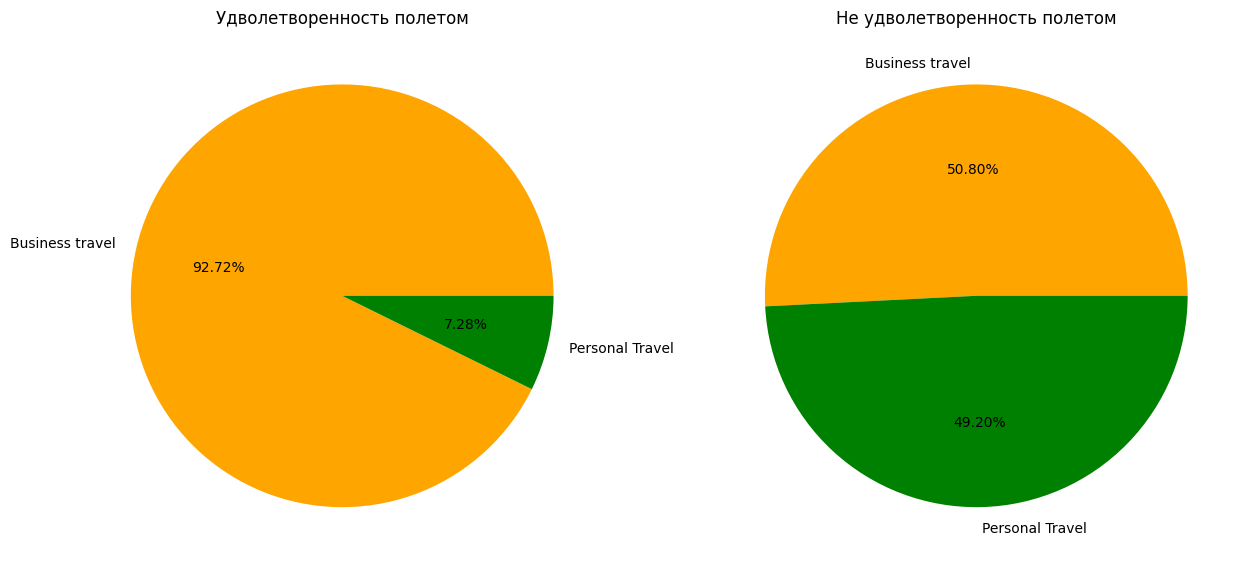

In [25]:
# 2. Теперь сравним категории пассажиров в зависимости от их цели поездки. Выберите все верные утверждения:
busines = df.groupby(by='satisfaction')['Type of Travel'].value_counts()
display(busines)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].pie(
    busines.loc['satisfied'],
    labels=['Business travel', 'Personal Travel'],
    colors=['orange', 'green'],
    autopct='%.2f%%',
)

axes[1].pie(
    busines.loc['neutral or dissatisfied'],
    labels=['Business travel', 'Personal Travel'],
    colors=['orange', 'green'],
    autopct='%.2f%%'
)

axes[0].set_title('Удволетворенность полетом')
axes[1].set_title('Не удволетворенность полетом')


satisfaction             Class   
neutral or dissatisfied  Eco         38044
                         Business    15185
                         Eco Plus     5650
satisfied                Business    34480
                         Eco          8701
                         Eco Plus     1844
Name: Class, dtype: int64

Text(0.5, 1.0, 'Не удволетворенность полетом')

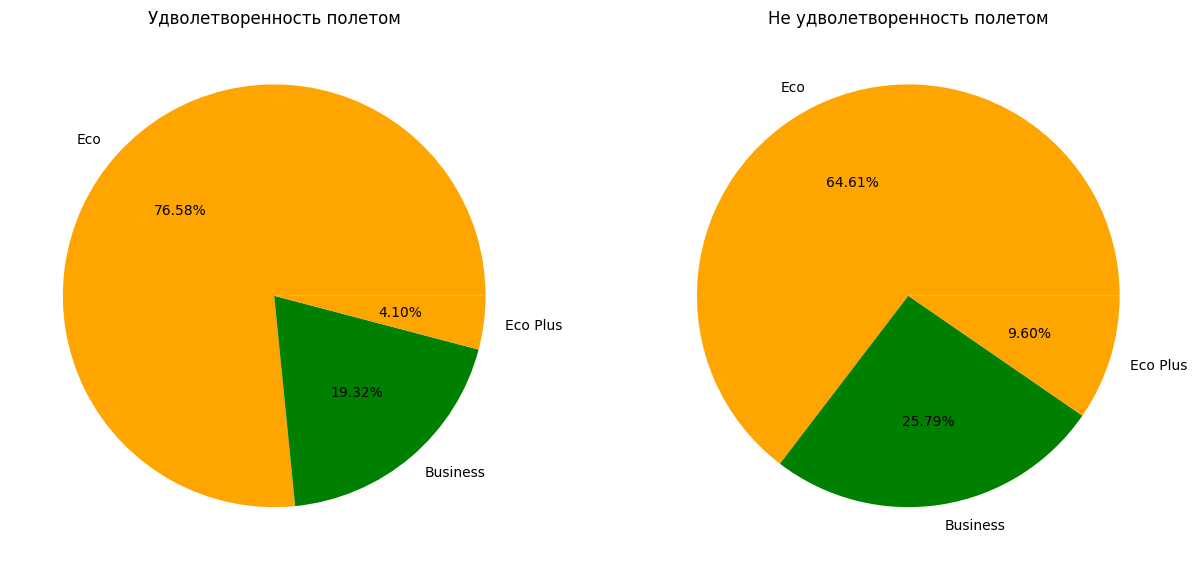

In [26]:
# 3. В каком туристическом классе наибольший процент довольных клиентов?
class_of_travel = df.groupby(by='satisfaction')['Class'].value_counts()
display(class_of_travel)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].pie(
    class_of_travel.loc['satisfied'],
    labels=['Eco', 'Business', 'Eco Plus'],
    colors=['orange', 'green'],
    autopct='%.2f%%',
)

axes[1].pie(
    class_of_travel.loc['neutral or dissatisfied'],
    labels=['Eco', 'Business', 'Eco Plus'],
    colors=['orange', 'green'],
    autopct='%.2f%%'
)

axes[0].set_title('Удволетворенность полетом')
axes[1].set_title('Не удволетворенность полетом')


In [27]:
# Перекодируем часть бинарных признаков, чтобы использовать их при обучении:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [28]:
# Задание 6.4
# Для остальных категориальных признаков создайте итту-переменные. Сделайте это с помощью функции get dummies () из библиотеки
# Pandas, параметры не меняйте. Сколько теперь признаков в данных (включая целевую переменную)?
dummy_cols = []

for i in df.columns:
    if df[i].dtype == 'O':
        dummy_cols.append(i)

df_dummy = pd.get_dummies(data=df, columns=dummy_cols)

len(df_dummy.columns)


26

In [29]:
# Задание 6.5
# Мы практически добрались до обучения модели. Разбейте данные на обучающую и тестовую выборки в соотношении 80/20, параметр
# random state = 26. Сколько наблюдений попало в тестовую выборку?
X = df_dummy.drop(['satisfaction'], axis=1)
y = df_dummy['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26)


X_test.shape[0]

20781

In [30]:
# Задание 6.6

# Теперь нам необходимо реализовать масштабирование данных. Для этого обучите на обучающей выборке метод StandardScaler () И С
# помощью него преобразуйте и обучающую, и тестовую выборки. Не забудьте, что целевую переменную обрабатывать не нужно.

# Примечание. Отметим, что если бы дальше мы работали только с деревьями, масштабирование бы не требовалось. Однако мы
# реализуем его, чтобы можно было обучать и другие модели и сравнивать полученные результаты.
# В качестве ответа введите самое первое значение из матрицы преобразованных признаков тестовой выборки. Округлите значение до двух
# знаков после точки-разделителя.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

round(X_test_scaled[0][0],2)

0.94

In [31]:
# Задание 6.7

# Перейдём к обучению моделей. В качестве первой модели возьмём самую простую - логистическую регрессию. Мы делаем это для того, чтобы
# потом сравнивать с ней полученные результаты: так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.
# Обучите логистическую регрессию с параметрами по умолчанию на наших данных. В качестве ответа введите значение метрики f1 score.
# Ответ округлите до трёх знаков после точки-разделителя.

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)

print(f'F1 score for the baseline modek: {f1_score(y_test, y_pred_logreg).round(3)}')


F1 score for the baseline modek: 0.855


In [32]:
# Задание 6.8

# Теперь перейдём к бустингу. Начнём с обучения первой модели - AdaBoost. В качестве базовой модели для неё возьмите решающее дерево с
# параметром random state = 26.
# Обучите AdaBoost, зафиксировав random state со значением 26 и задав темп обучения 0.01. В качестве ответа введите значение метрики
# fl score. Ответ округлите до трёх знаков после точки-разделителя.

tree = DecisionTreeClassifier(random_state=26)
ada_classif = AdaBoostClassifier(estimator=tree, random_state=26, learning_rate=0.01)

ada_classif.fit(X_train_scaled, y_train)

ada_pred = ada_classif.predict(X_test_scaled)

print(f'F1 score on test for ADA: {f1_score(y_test, ada_pred).round(3)}')


F1 score on test for ADA: 0.94


In [33]:
# Задание 6.9

# Перейдем к следующему алгоритму - градиентному бустингу.
# Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:
# params = {"_estimators":2**p.arange (8), "learning_rate": 0.1**p.arange (3)}
# Используйте для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма задайте параметр кросс-валидации, равный
# 3.
# Какое наибольшее значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
scoring = make_scorer(f1_score)
estimator = GradientBoostingClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
y_pred_gs = grid_search.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred_gs).round(3)

print(f'Best score on train for gbm: {round(grid_search.best_score_,3)}')
print(f'Best score on test for gbm: {f1}')

Best score on train for gbm: 0.949
Best score on test for gbm: 0.951


In [34]:
# Задание 6.10

# Обучите алгоритм XGBoost. Так как он достаточно мощный «из коробки», определите его с параметрами по умолчанию, только задайте
# random state = 26. Какое значение метрики f1 _score получилось? Ответ округлите до трёх знаков после точки-разделителя.

# Подсказка. Для того чтобы обучить алгоритм XGBoost для решения задачи классификации, вам понадобится XGBClassifier И3
# библиотеки xgboost, установленной ранее. Вся дальнейшая последовательность действий (обучение модели, предсказание, оценка
# качества) идентична другим алгоритмам, например логистической регрессии.

xgb = XGBClassifier(random_state=26)
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

print(f'F1 on xgb: {f1_score(y_test, y_pred_xgb).round(3)}')


F1 on xgb: 0.958


In [35]:
# Задание 6.11

# Обучите алгоритм CatBoost. Как и XGBoost, будем обучать его с настройками по умолчанию и заданным random state = 26. Какое значение
# метрики f1 score получилось? Ответ округлите до трех знаков после точки-разделителя.

# Подсказка. Для того чтобы обучить алгоритм CatBoost, вам понадобится CatBoostClassifier () из библиотеки catboost, установленной
# ранее. Вся дальнейшая последовательность действий (обучение модели, предсказание, оценка качества) идентична другим алгоритмам,
# например логистической регрессии.
cat = CatBoostClassifier(random_state=26)
cat.fit(X_train_scaled, y_train)

y_pred_cat = cat.predict(X_test_scaled)

print(f'F1 on catboost for test: {f1_score(y_test, y_pred_cat).round(3)}')
cat.best_score_

Learning rate set to 0.068023
0:	learn: 0.6018180	total: 19.2ms	remaining: 19.2s
1:	learn: 0.5020757	total: 25.5ms	remaining: 12.7s
2:	learn: 0.4472475	total: 31.6ms	remaining: 10.5s
3:	learn: 0.4028686	total: 37.6ms	remaining: 9.36s
4:	learn: 0.3674732	total: 43.7ms	remaining: 8.69s
5:	learn: 0.3397844	total: 50ms	remaining: 8.28s
6:	learn: 0.3121216	total: 56.2ms	remaining: 7.97s
7:	learn: 0.2917501	total: 62ms	remaining: 7.68s
8:	learn: 0.2749040	total: 68ms	remaining: 7.49s
9:	learn: 0.2575191	total: 73.9ms	remaining: 7.32s
10:	learn: 0.2473690	total: 79.9ms	remaining: 7.18s
11:	learn: 0.2377533	total: 86.3ms	remaining: 7.1s
12:	learn: 0.2279311	total: 92.1ms	remaining: 6.99s
13:	learn: 0.2212511	total: 98.2ms	remaining: 6.92s
14:	learn: 0.2100357	total: 105ms	remaining: 6.88s
15:	learn: 0.2025732	total: 111ms	remaining: 6.82s
16:	learn: 0.1942301	total: 117ms	remaining: 6.75s
17:	learn: 0.1877937	total: 123ms	remaining: 6.72s
18:	learn: 0.1832380	total: 130ms	remaining: 6.72s
19:	

{'learn': {'Logloss': 0.05729460095780446}}

In [36]:
# Задание 6.12

# Выведите матрицу ошибок для алгоритма, который получил наилучшие показатели качества модели на обучающей выборке (будем считать,
# что оцениваем по fl score). Матрица ошибок выводится в следующем формате:
# Значения в матрице ошибок переведите в проценты от общего числа наблюдений в обучающей выборке и округлите до целых.

# Подсказка. Для того чтобы построить матрицу ошибок в CatBoost, необходимо использовать следующий шаблон:
# get confusion matrix (модель, Роо1 (признаки обучающей выборки, целевая переменная обучающей выборки) )
# Более подробно построение матрицы ошибок можно изучить в документации.

# Заполните соответствующие значения (в процентах от общего числа наблюдений в обучающей выборке, округленных до целого):
cm = get_confusion_matrix(cat, Pool(X_train_scaled, y_train))
cm_perc = cm/y_train.shape[0]*100
cm_perc.round()


array([[56.,  1.],
       [ 2., 42.]])

<AxesSubplot: >

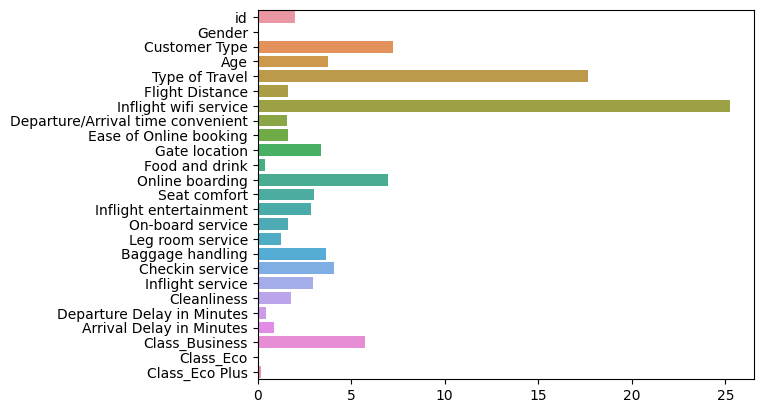

In [37]:
# Задание 6.13

# Оцените важность признаков для модели из предыдущего задания. Отметьте признак, который оказывает наибольшее влияние на значение
# целевой переменной:

sns.barplot(
    x=cat.feature_importances_,
    y=X_train.columns,
)